Set paths:

In [1]:
inputPath <- "Data/"
outputPath <- "Output/Graphs/"

Load necessary packages:

In [2]:
load_packages = c("nlme", "scam", "mgcv",  "readr", "tidyr", "purrr", "ggplot2", "lubridate", "gridExtra", "broom", "zoo", "plyr", "stringr", "dplyr", "stats")
shh <- suppressMessages(suppressWarnings(lapply(c(load_packages), library, character.only = TRUE, warn.conflicts = FALSE)))
rm(shh)

Load necessary functions

In [3]:
suppressMessages(suppressWarnings(source("Data/models/Spline_QMER.R", verbose = FALSE, echo = FALSE)))
suppressMessages(suppressWarnings(source("Data/models/FitSpATS.R", verbose = FALSE)))
suppressMessages(suppressWarnings(source("Data/models/Graphs.R", verbose = FALSE)))
suppressMessages(suppressWarnings(source("Data/models/PsplinesREML.R", verbose = FALSE)))

Read in data of 12 genotypes with 2 replications which results in 24 plots. 

In [4]:
#read in data and structure columns
indat <- read.table(paste0(inputPath,"FPWW018_CnpHgt_CPCourse_subset.csv"),header = T, sep=",", skip=2) %>% 
  mutate_at(vars(2:7),as.factor) %>%  
  mutate(date = as.POSIXct(strptime(date, "%Y.%m.%d")), 
         height.cor = height.cor *1000) 

#rename columns: 
names(indat) = names(indat)  %>% 
    gsub("Plot_ID", "plot.UID", .) %>% 
    gsub("height.cor", "value", .) %>% 
    gsub("Gen_ID", "genotype_id", .) %>% 
    gsub("Gen_Name", "genotype_name", .)

#convert timestamp to date formate and remove unnecessary column
indat$timestamp = paste0(indat$date, " 10:13:00")
indat$timestamp = as.POSIXct(indat$timestamp, tz = "GMT", "%Y-%m-%d %H:%M:%S")
indat = indat %>% select(-Plot)

Add design information to the data:

In [5]:
#read in design data 
design1 <- read.table(paste0(inputPath,"designs.csv"),header = T, sep=",")
design2 <- read.table(paste0(inputPath,"designs_2.csv"),header = T, sep=",")
design = bind_rows(design1, design2) %>% select(-genotype_id)

#merge design to data file 
data = left_join(indat, design, by=c("plot.UID" = "UID"))

Add covariate information to the data. In this exercise we use growing degree days (GDD) as covariates.

In [6]:
#Read growing degree days as covariates
covFPWW018   <- read.csv(paste0(inputPath,"cov_FPWW018.csv"),header = T) %>% 
  # bring date in same format as other data
  mutate(date = as.POSIXct(as.character(Date), format = "%Y-%m-%d")) %>%  
  # calculate GDD for each date by cumulating the daily temperature
  mutate(GDD = cumsum(Tsum))

#add covariate information to the data
dat <- left_join(data,select(covFPWW018,date,GDD,Tmean), by="date")

To find out where the growth rate is maximal, we need to calculate the growth rate for each measurement timepoint. In order to do this, we order the measurement timepoints separately for each genotype, and calculate the differences in height between the measurment timepoints. The first timepoint will therefore have no growth rate and we delete this timepoint. Finally, the time difference between the measurement timepoints is calculate which is needed in further processing. 

In [7]:
# Add timepoint of preliminar measurement and value delta (growth) to each timepoint
df_values_for_fit <- dat %>%
  dplyr::group_by(plot.UID) %>% 
  dplyr::arrange(timestamp) %>% 
  mutate(lag_timestamp = dplyr::lag(timestamp), value_delta = value - lag(value))

# Remove first measurements, they do not suite as delta measurement
df_values_for_fit <- df_values_for_fit %>% filter(!is.na(lag_timestamp))

# Calculate measurement time point shifts in hours
df_values_for_fit <- df_values_for_fit %>%
  group_by(plot.UID) %>%
  mutate(time_diff = difftime(timestamp, lag_timestamp, units = "hours"))


Now, let's fit a logistic regression. The function logistic_regression() uses the measured height data to fit a logistic regression. In a next step, new height values are predicted in a time interval of 0.5 days or 10 GDD (depending on the input) using the parameters from the fitted model. Then, the QMER model with chosen parameters is applied. The function output is a graph of the chosen plot with measured height at 22 timepoints (black points), fitted logistic regression (black line), timepoint of highest growth rate (xmid, dashed line), and the three extracted traits (start of stem elongation as a thick green line, stop of stem elongation as a thin green line, and final height as a red line). 

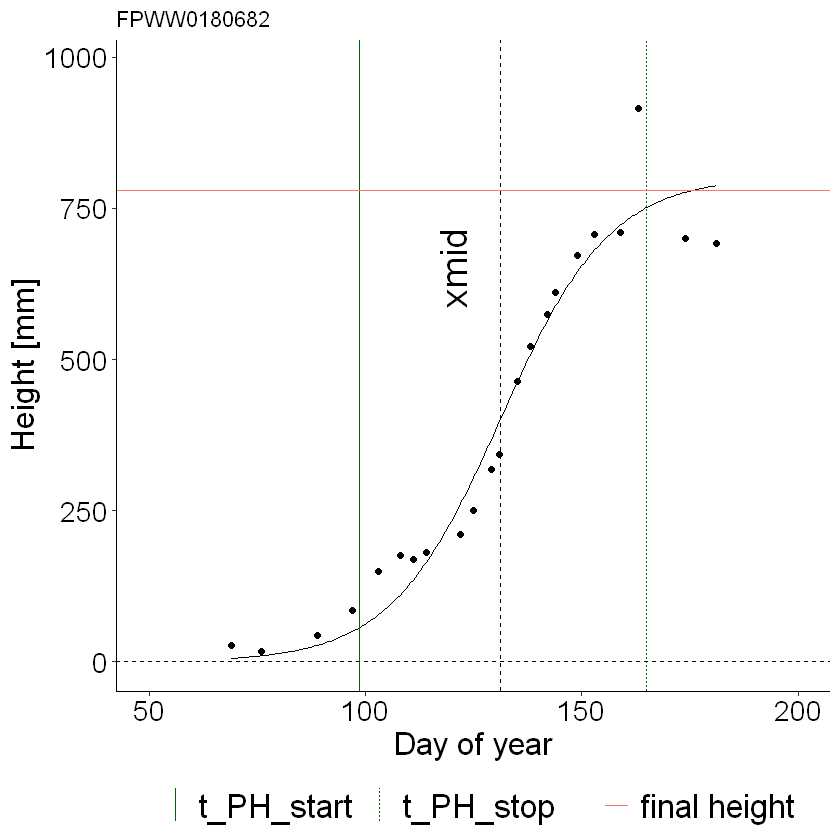

In [8]:
#axis = "doy" or "GDD"
axis = "doy"

#fit a logistic regression
logistic_regression(df = df_values_for_fit, axis = axis, p = "FPWW0180682", threshold_start = 1 / 4, threshold_stop = 1 / 4, final_height_agg = 24)

As you can see, this is a very bad fit. Especially at the end of the growth curve, there is a strong deviation between the measured height and the fitted logistic regression. The measurments seems to be very compressed. Let's change the x-axis from day of year to growing degree days to find out if the fit improves. Change the argument in the function logistic_regression() from "doy" to "GDD" and run the model again. 

**Question 1.1: Compare the model fit. Would you use growing degree days or day of year for the x-axis?**


A second reason for the bad fit might be due to the third last measurement point which is potentially an outlier. In this exercise, we are not going to check if this measurement is actually an outlier. In reality, we would check for example the images and try to find out if something went wrong. Here, we are going to remove this datapoint and check the model fit again.  

Answer:

In [9]:
#remove an outlier: 
dat_rm = dat %>% filter(date != "2017-06-12")

Do the same data transformation without the outlier:

In [10]:
# Add timepoint of preliminar measurement and value delta (growth) to each timepoint
df_values_for_fit_rm <- dat_rm %>%
  dplyr::group_by(plot.UID) %>% 
  dplyr::arrange(timestamp) %>% 
  mutate(lag_timestamp = dplyr::lag(timestamp), value_delta = value - lag(value))

# Remove first measurements, they do not suite as delta measurement
df_values_for_fit_rm <- df_values_for_fit_rm %>% filter(!is.na(lag_timestamp))

# Calculate measurement time point shifts in hours
df_values_for_fit_rm <- df_values_for_fit_rm %>%
  group_by(plot.UID) %>%
  mutate(time_diff = difftime(timestamp, lag_timestamp, units = "hours"))

Fit again a logistic regression and predict a growth curve

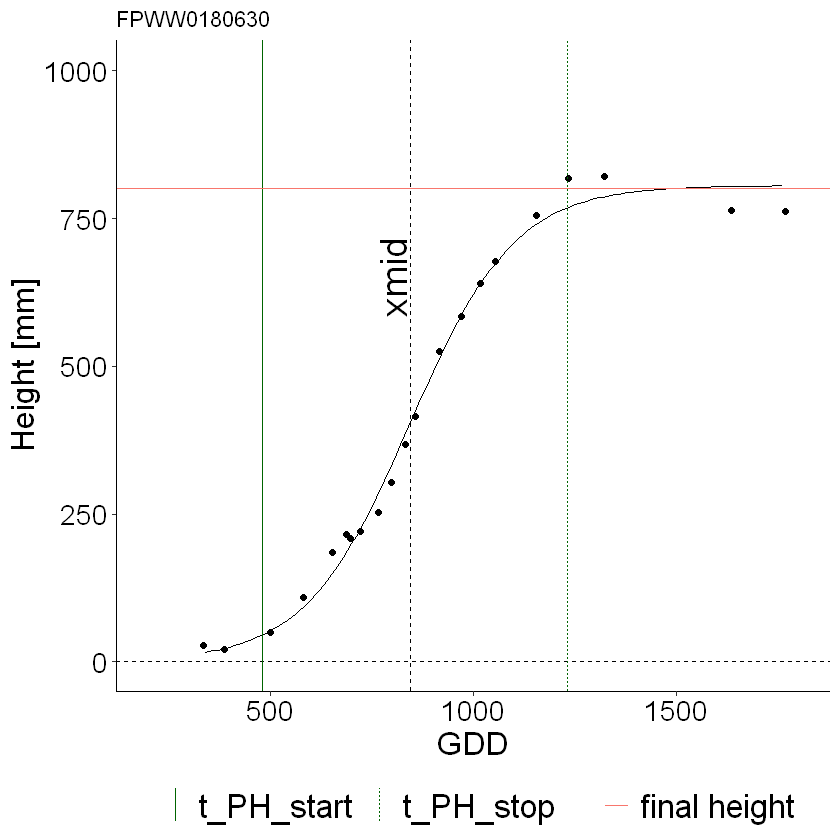

In [11]:
#axis = "doy" or "GDD"
logistic_regression(df= df_values_for_fit_rm, axis = "GDD", p = "FPWW0180630", threshold_start = 1 / 5, threshold_stop = 1 / 5 , final_height_agg = 50)

**Question 1.2: Compare the model fit between the model with the outlier and without the outlier. Are there differences between GDD or DOY on the x-axis?**

The model fit has improved a lot after removing the outlier. Let's now focus on the extraction of start and stop of stem elongation as well as the final canopy height. 

**Question 1.3: Do you think the the start and stop of stem elongation were extracted at the right time point? Or too early / too late? Try different thresholds for the start and stop of stem elongation. For this, change the argument in the function above and run the code again. How do you need to change the values in order to get an earlier or later start and stop of stem elongation? What about the final height? Can you find an optimal combination?**

For the start of stem elongation, it is quite difficult to find an optimal threshold since the height of the second measurement is lower than the first and the third one, and the fitted regression follows the second point. 
Now, set the threshold for start and end of stem elongation to 1/5, and final_height_agg to 50. The fit looks quite good. Change to plot number to "FPWW0180630" and run the model again. 

**Question 1.4: Do you think the trait extraction is still accurate? What happened at the end of the crop growth (why are the last to measurement points lower?)**


Answer:

You just saw that a logistic regression has its difficulties to nicely model crop growth in the field which usually includes some noise (due to the environment, the measurement method or lodging). Furthermore, a good trait extraction for one plot could be a bad trait extraction for a different plot. Let's model crop growth using p-Splines, which are way more flexible. 

Warning message in inner_join(predicts, indat %>% dplyr::select(plot.UID, Rep), :
"Detected an unexpected many-to-many relationship between `x` and `y`.
i Row 1 of `x` matches multiple rows in `y`.
i Row 1 of `y` matches multiple rows in `x`.
i If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning."


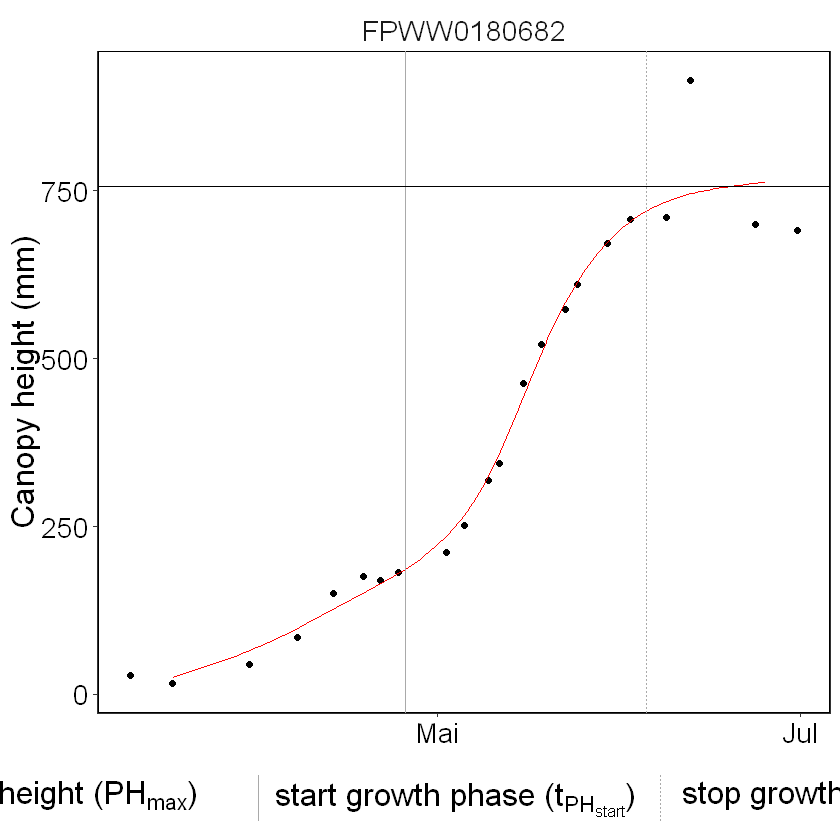

In [12]:
splines(dat = df_values_for_fit, p = "FPWW0180682", threshold_start = 1 / 4, threshold_stop = 1 / 4, final_height_agg = 24)


The outlier exacerbates again crop growth modelling. Run the model again without the outliert (code below with the argument dat = df_values_for_fit_rm)  

Warning message in inner_join(predicts, indat %>% dplyr::select(plot.UID, Rep), :
"Detected an unexpected many-to-many relationship between `x` and `y`.
i Row 1 of `x` matches multiple rows in `y`.
i Row 1 of `y` matches multiple rows in `x`.
i If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning."


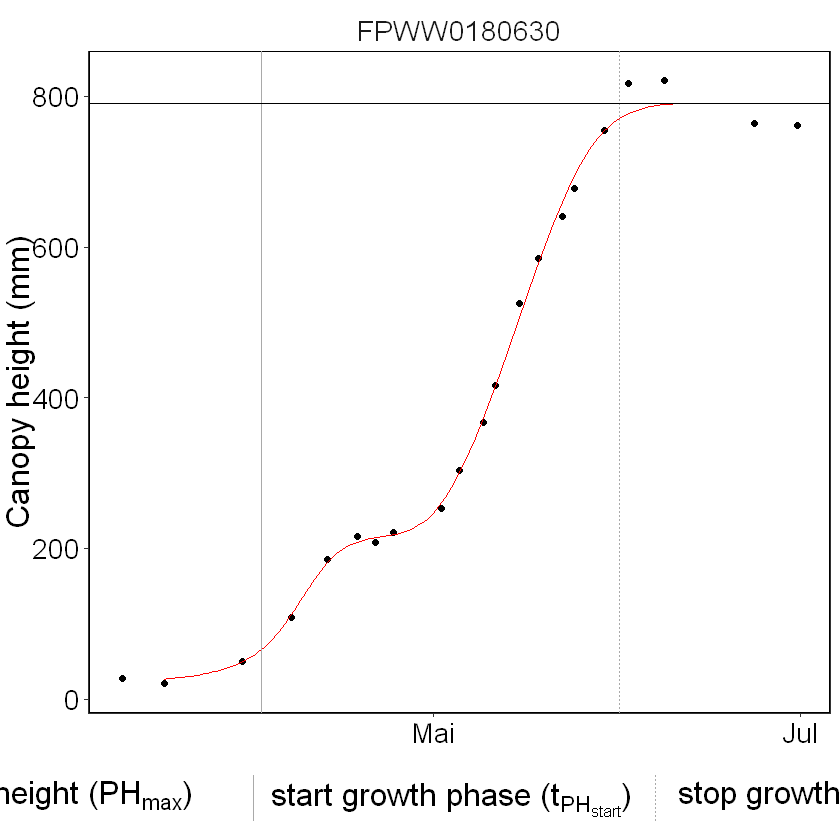

In [13]:
splines(dat = df_values_for_fit_rm, p = "FPWW0180630", threshold_start = 1 / 4, threshold_stop = 1 / 4, final_height_agg = 24)

The red line follows the measurement points more closely. 

**Question 2.1: Do you think that the trait extraction is accurate? Change the parameters in the function above again to find an optimal solution. Can you find one?**

Change the plot number in the  model above to "FPWW0180630".

**Question 2.2: How accurate is the trait extraction for a different plot?**

Answer:

A different method to extract start and stop of stem elongation is to use the second derivative. With the two functions below, you can plot both methods in the same plot. In the first plot, crop growth is modelled using p-splines, in the second plot a logistic function. 

Warning message in inner_join(predicts, indat %>% dplyr::select(plot.UID, Rep), :
"Detected an unexpected many-to-many relationship between `x` and `y`.
i Row 1 of `x` matches multiple rows in `y`.
i Row 1 of `y` matches multiple rows in `x`.
i If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning."


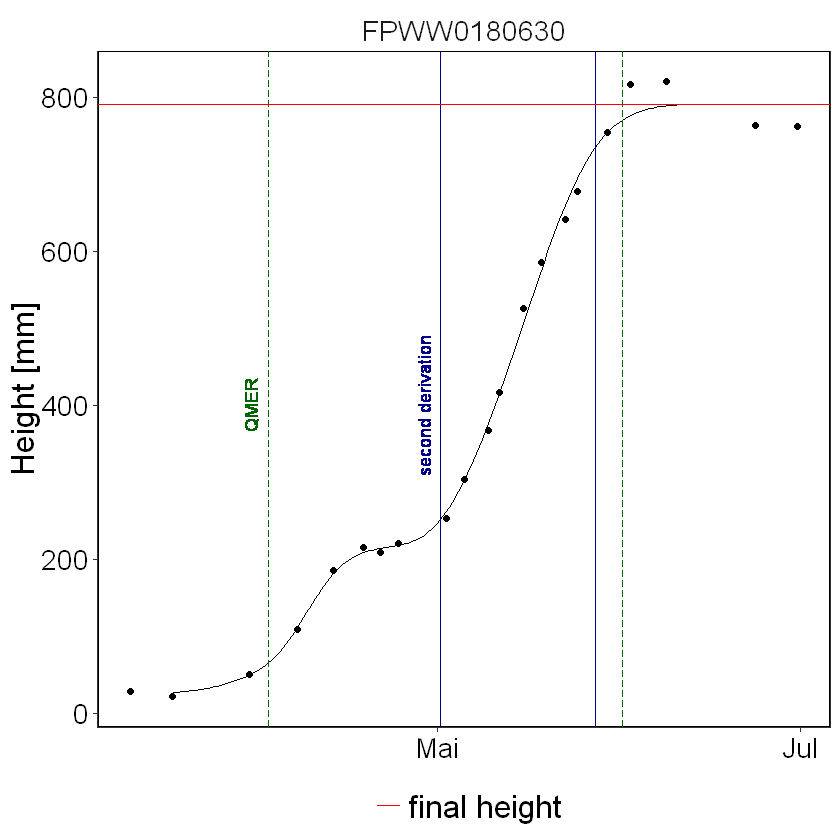

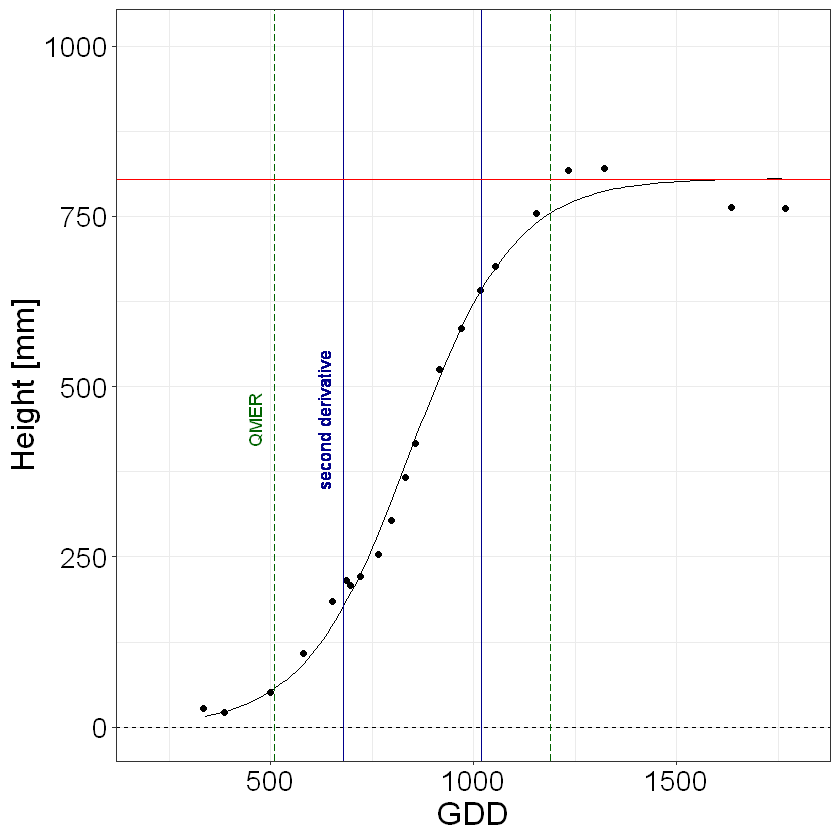

In [14]:
#axis = "doy" or "GDD"
plot = "FPWW0180630"
splines_deriv(dat = df_values_for_fit_rm, p = plot, threshold_start = 1 / 4, threshold_stop = 1 / 4, final_height_agg = 24) 
logistic_regression_deriv(df= df_values_for_fit_rm, axis = "GDD", p = plot, threshold_start = 1 / 4, threshold_stop = 1 / 4 , final_height_agg = 24)

**Question 3.1: Compare the different extraction methods. Is there a method which works better? Try out different plots (change plot = "FPWW0180682" to a different plot in the first row) and parameters in the code above.**

Answer:

**Question 3.2: How would you find out if the extracted timepoint is the correct start of stem elongation?**

Answer:

**Summary of exercise:**

QMER method chooses earlier start of stem elongation and later stop of stem elongation than the second derivation. QMER seems to be more stable across different modelling methods. 

QMER is a trait extraction method which can be applied to crop growth modelled using logistic regression or p-splines. QMEr performs more or less equally well for both modelling strategies. 

Extracting final height is more challenging than extracting the start and end of stem elongation because some genotypes might lodge after some time. The best option here is to plot crop growth of different genotypes, and to check if many different genotypes lodged at some timepoints. There was usually a storm which caused them to lodge. When we see a pattern, we can unhesistatingly delete these timepoints. To do this, we need enough measurements at the end of the crop growth (there were definitely not enough measurement in this example).

QMER method migh also struggle if there is a sudden increase in growth, and a subsequent stagnation around start of stem elongation. The method will most likely determine the start of stem elongation befor the increase in growth for some genotypes, and after the increase for different gentoypes (show example). In such a case, we try to adapt the threshold for start of stem elongation and compare the graphs of different gentoypes. 

To find out which timepoint is best, we calculate heritability of the trait, or to be more accuarate, we perform a genomic prediction (which takes some time). In this way, we are able to find out how heritable this trait is. 



$y\frac{asym}{1 + e^{-(x-xmid) / scal} }$